## Importing libraries and packages

In [2]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

## 1. Loading data :
Loading a single image, pose, and camera intrinsics from the Blender ficus dataset.
    

Image Shape: (128, 128, 3)

Camera-to-World Pose Matrix:
 [[-9.90379214e-01 -2.33055409e-02  1.36404201e-01  5.49862862e-01]
 [ 1.38380826e-01 -1.66795656e-01  9.76232648e-01  3.93531919e+00]
 [-1.86264537e-09  9.85715985e-01  1.68415993e-01  6.78906500e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Calculated Focal Length: 177.77776499100293


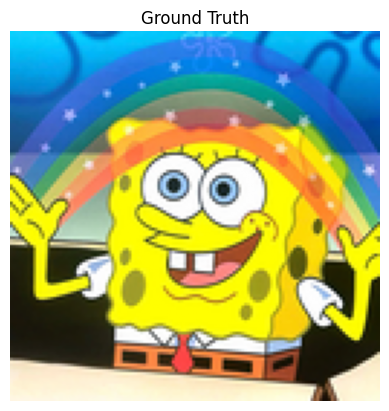

In [27]:
def load_image_with_pose(dataset_dir, img_size=(128, 128)):

    camera_angle_x = 0.6911112070083618

    transform_matrix = [
        [-0.9903792142868042, -0.023305540904402733, 0.13640420138835907, 0.5498628616333008],
        [0.13838082551956177, -0.16679565608501434, 0.976232647895813, 3.935319185256958],
        [-1.862645371275562e-09, 0.9857159852981567, 0.16841599345207214, 0.6789065003395081],
        [0.0, 0.0, 0.0, 1.0]
    ]

    img = 'imagination.png'

    # 2. Construct the full path to the image file.
    img_path = os.path.join(dataset_dir, img)

    # 3. Load and process the image (same as before).
    image = Image.open(img_path).resize(img_size, Image.LANCZOS)
    image = np.array(image) / 255.0 # Normalize to [0, 1]

    # Extract RGB channels (assumes input is RGBA).
    rgb = image[..., :3]

    # The pose is the camera-to-world transformation matrix.
    pose = np.array(transform_matrix)

    # The focal length is calculated from the camera's horizontal field of view.
    focal = 0.5 * img_size[0] / np.tan(0.5 * camera_angle_x)

    return rgb, pose, focal


# Path to the base directory of your dataset.
dataset_base_dir = 'data/'

# Load the image and its corresponding, hardcoded camera data.
image, camera_to_world, focal_length = load_image_with_pose(dataset_base_dir, img_size=(128, 128))
height, width = image.shape[:2]

# Print the loaded data to verify
print("Image Shape:", image.shape)
print("\nCamera-to-World Pose Matrix:\n", camera_to_world)
print("\nCalculated Focal Length:", focal_length)

# Display the image
plt.imshow(image)
plt.title('Ground Truth')
plt.axis('off')
plt.show()

## 2. Ray Generation
This step connects the 2D image to the 3D world. For every pixel in the 128x128 image, it calculates a unique 3D ray.
Each ray has an origin (the camera's 3D location) and a direction vector that points from the camera, through that pixel and out into the scene. That results in a set of 10,000 rays, one for each pixel

In [20]:
def generate_camera_rays(height, width, focal_length, camera_to_world):
    # Create a grid of pixel coordinates (i: x-axis, j: y-axis)
    i, j = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')

    # Compute ray directions in camera space
    x = (i - width / 2) / focal_length
    y = -(j - height / 2) / focal_length
    z = -np.ones_like(x)
    directions_camera = np.stack([x, y, z], axis=-1)  # Shape: (H, W, 3)

    # Transform ray directions to world space
    directions_world = directions_camera @ camera_to_world[:3, :3].T

    # All rays originate from the camera origin in world space
    origins_world = np.broadcast_to(camera_to_world[:3, 3], directions_world.shape)

    return origins_world, directions_world

ray_origins, ray_directions = generate_camera_rays(height, width, focal_length, camera_to_world)


## 3. Point Sampling Along Rays
The neural network needs 3D points to evaluate, not just rays. This function takes each of the 10,000 rays and samples 32 distinct 3D points (x, y, z) along its path.
These points are spaced evenly between a near and a far boundary, defining the volume in space where the object is expected to be.


In [21]:

def sample_points_along_rays(ray_origins, ray_directions, near, far, num_samples):
    z_values = np.linspace(near, far, num_samples)
    points = ray_origins[..., None, :] + ray_directions[..., None, :] * z_values[None, None, :, None]
    return points, z_values

num_samples_per_ray = 32
near_bound, far_bound = 2.0, 6.0
sampled_points, z_values = sample_points_along_rays(ray_origins, ray_directions, near_bound, far_bound, num_samples_per_ray)


## Neural Network Definition
This is the core of the NeRF: a simple neural network. Its job is to act as a "function of the scene." It takes a single 3D coordinate (x, y, z) as input and predicts two things at that specific point in space: its color (r, g, b) and its density (sigma). A high density means the point is opaque, while a low density means it's transparent.

In [23]:
class NeRFNetwork(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 4)  # Output: (r, g, b, sigma)
        )

    def forward(self, x):
        return self.mlp(x)

# Instantiate the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeRFNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

## 5. Volume Rendering Function
Volume rendering simulates the way light passes through a semi-transparent medium (like fog, smoke, or 3D scenes) and accumulates color and opacity along a ray.

This is how an image is created from the Neural Network's predictions. For a single ray, it takes the 32 predicted colors and densities from the sampled points. Using the volume rendering equation, it composites them together, correctly blending the colors based on their density and distance. Points closer to the camera can block (occlude) points further away. The final output is a single pixel color for that ray.



In [24]:


def volume_render_radiance_field(rgb_sigma, z_values, ray_directions):
    """
    Args:
        rgb_sigma (Tensor): Raw output from the network of shape (num_rays, num_samples, 4).
                            The last channel is sigma (density), and the first three are RGB.
        z_values (Tensor): Sampled depth values along each ray, shape (num_samples,).
        ray_directions (Tensor): Ray directions, shape (num_rays, 3).

    Returns:
        rgb_map (Tensor): Rendered RGB color for each ray, shape (num_rays, 3).
    """
    # Separate RGB and density (sigma), applying activation functions
    rgb = torch.sigmoid(rgb_sigma[..., :3])          # (num_rays, num_samples, 3)
    # sigma = F.relu(rgb_sigma[..., 3])                # (num_rays, num_samples)
    sigma = F.softplus(rgb_sigma[..., 3])    # (num_rays, num_samples)

    # Compute distances between consecutive samples along each ray
    dists = z_values[1:] - z_values[:-1]             # (num_samples - 1,)
    dists = torch.cat([dists, torch.tensor([1e10], device=z_values.device)])  # (num_samples,)
    dists = dists.unsqueeze(0).expand(ray_directions.shape[0], -1)            # (num_rays, num_samples)

    # Scale distances by the length of each ray
    ray_lengths = torch.norm(ray_directions, dim=-1, keepdim=True)           # (num_rays, 1)
    dists = dists * ray_lengths                                              # (num_rays, num_samples)

    # Compute alpha values from sigma
    alpha = 1.0 - torch.exp(-sigma * dists)                                  # (num_rays, num_samples)

    # Compute transmittance (T) and sample weights
    T = torch.cumprod(
        torch.cat([
            torch.ones((alpha.shape[0], 1), device=alpha.device),
            1.0 - alpha + 1e-10
        ], dim=-1),
        dim=-1
    )[:, :-1]

    weights = alpha * T                                                      # (num_rays, num_samples)

    # Composite RGB values using the weights
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)                    # (num_rays, 3)

    return rgb_map


## 6. Prepare Training Data
To train efficiently on a GPU, the data (sampled points, ray directions, and target pixel colors) is "flattened" from 120x120 structure into long, one-dimensional lists.
It also converts the NumPy arrays into PyTorch Tensors.

In [28]:

# Flatten rays and image for batch processing
num_rays = height * width

points_flat = torch.from_numpy(sampled_points.reshape(-1, num_samples_per_ray, 3)).float().to(device)
ray_directions_flat = torch.from_numpy(ray_directions.reshape(-1, 3)).float().to(device)
target_rgb_flat = torch.from_numpy(image.reshape(-1, 3)).float().to(device)

z_values_tensor = torch.from_numpy(z_values).float().to(device)

# Flatten rays and image for batch processing
num_rays = height * width




## 7. Training Loop
This is where the learning happens. The loop repeats num_training_steps times, and in each step it:
- Forward Pass: Feeds all the sampled 3D points to the MLP to get color and density predictions.
- Render: Uses the volume rendering function to turn those predictions into a full image.
- Calculate Loss: Compares the rendered image with the ground truth image using Mean Squared Error (MSE) to see how "wrong" the prediction is.
- Optimize: Uses the error to calculate how to adjust the MLP's weights to make a better prediction in the next step (this is backpropagation).

In [35]:

num_training_steps = 5000
for step in tqdm(range(num_training_steps), desc="Training NeRF"):
    # Predict color and density for all points along all rays
    rgb_sigma = model(points_flat)  # (num_rays, num_samples, 4)
    rgb_sigma = rgb_sigma.view(-1, num_samples_per_ray, 4)

    # Volume render to get final pixel colors
    rendered_rgb = volume_render_radiance_field(rgb_sigma, z_values_tensor, ray_directions_flat)

    # Compute loss
    loss = F.mse_loss(rendered_rgb, target_rgb_flat)

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 100 == 0:
        print(f"Step {step:4d} | Loss: {loss.item():.6f}")


Training NeRF:   0%|          | 5/5000 [00:00<02:05, 39.95it/s]

Step    0 | Loss: 0.019758


Training NeRF:   2%|▏         | 109/5000 [00:02<01:41, 48.26it/s]

Step  100 | Loss: 0.019592


Training NeRF:   4%|▍         | 209/5000 [00:04<01:41, 47.37it/s]

Step  200 | Loss: 0.019406


Training NeRF:   6%|▌         | 309/5000 [00:06<01:37, 48.13it/s]

Step  300 | Loss: 0.019643


Training NeRF:   8%|▊         | 409/5000 [00:08<01:36, 47.82it/s]

Step  400 | Loss: 0.019155


Training NeRF:  10%|█         | 509/5000 [00:10<01:34, 47.73it/s]

Step  500 | Loss: 0.019738


Training NeRF:  12%|█▏        | 609/5000 [00:12<01:31, 47.87it/s]

Step  600 | Loss: 0.019525


Training NeRF:  14%|█▍        | 709/5000 [00:14<01:29, 47.72it/s]

Step  700 | Loss: 0.019909


Training NeRF:  16%|█▌        | 809/5000 [00:16<01:28, 47.16it/s]

Step  800 | Loss: 0.019133


Training NeRF:  18%|█▊        | 909/5000 [00:18<01:25, 47.98it/s]

Step  900 | Loss: 0.019058


Training NeRF:  20%|██        | 1009/5000 [00:21<01:23, 47.81it/s]

Step 1000 | Loss: 0.019720


Training NeRF:  22%|██▏       | 1109/5000 [00:23<01:21, 47.89it/s]

Step 1100 | Loss: 0.018877


Training NeRF:  24%|██▍       | 1209/5000 [00:25<01:19, 47.75it/s]

Step 1200 | Loss: 0.019827


Training NeRF:  26%|██▌       | 1309/5000 [00:27<01:18, 47.28it/s]

Step 1300 | Loss: 0.018769


Training NeRF:  28%|██▊       | 1409/5000 [00:29<01:15, 47.34it/s]

Step 1400 | Loss: 0.019207


Training NeRF:  30%|███       | 1509/5000 [00:31<01:13, 47.65it/s]

Step 1500 | Loss: 0.018861


Training NeRF:  32%|███▏      | 1609/5000 [00:33<01:11, 47.74it/s]

Step 1600 | Loss: 0.018565


Training NeRF:  34%|███▍      | 1709/5000 [00:35<01:08, 47.91it/s]

Step 1700 | Loss: 0.018622


Training NeRF:  36%|███▌      | 1809/5000 [00:37<01:06, 47.86it/s]

Step 1800 | Loss: 0.019061


Training NeRF:  38%|███▊      | 1909/5000 [00:39<01:04, 47.64it/s]

Step 1900 | Loss: 0.018474


Training NeRF:  40%|████      | 2009/5000 [00:42<01:02, 47.52it/s]

Step 2000 | Loss: 0.018427


Training NeRF:  42%|████▏     | 2109/5000 [00:44<01:00, 47.79it/s]

Step 2100 | Loss: 0.018860


Training NeRF:  44%|████▍     | 2209/5000 [00:46<00:58, 47.96it/s]

Step 2200 | Loss: 0.018193


Training NeRF:  46%|████▌     | 2309/5000 [00:48<01:00, 44.64it/s]

Step 2300 | Loss: 0.018619


Training NeRF:  48%|████▊     | 2409/5000 [00:50<00:54, 47.82it/s]

Step 2400 | Loss: 0.018238


Training NeRF:  50%|█████     | 2509/5000 [00:52<00:52, 47.32it/s]

Step 2500 | Loss: 0.018601


Training NeRF:  52%|█████▏    | 2609/5000 [00:54<00:49, 47.89it/s]

Step 2600 | Loss: 0.018378


Training NeRF:  54%|█████▍    | 2709/5000 [00:56<00:47, 47.91it/s]

Step 2700 | Loss: 0.018108


Training NeRF:  56%|█████▌    | 2809/5000 [00:58<00:45, 47.70it/s]

Step 2800 | Loss: 0.018559


Training NeRF:  58%|█████▊    | 2909/5000 [01:01<00:43, 48.08it/s]

Step 2900 | Loss: 0.018656


Training NeRF:  60%|██████    | 3009/5000 [01:03<00:41, 47.48it/s]

Step 3000 | Loss: 0.018563


Training NeRF:  62%|██████▏   | 3109/5000 [01:05<00:39, 47.64it/s]

Step 3100 | Loss: 0.018810


Training NeRF:  64%|██████▍   | 3209/5000 [01:07<00:37, 48.23it/s]

Step 3200 | Loss: 0.017789


Training NeRF:  66%|██████▌   | 3309/5000 [01:09<00:35, 48.18it/s]

Step 3300 | Loss: 0.018106


Training NeRF:  68%|██████▊   | 3409/5000 [01:11<00:32, 48.38it/s]

Step 3400 | Loss: 0.017687


Training NeRF:  70%|███████   | 3509/5000 [01:13<00:30, 48.30it/s]

Step 3500 | Loss: 0.017961


Training NeRF:  72%|███████▏  | 3609/5000 [01:15<00:29, 47.63it/s]

Step 3600 | Loss: 0.018136


Training NeRF:  74%|███████▍  | 3709/5000 [01:17<00:26, 48.09it/s]

Step 3700 | Loss: 0.017669


Training NeRF:  76%|███████▌  | 3809/5000 [01:19<00:24, 48.19it/s]

Step 3800 | Loss: 0.017798


Training NeRF:  78%|███████▊  | 3909/5000 [01:21<00:22, 48.17it/s]

Step 3900 | Loss: 0.018305


Training NeRF:  80%|████████  | 4009/5000 [01:23<00:20, 48.06it/s]

Step 4000 | Loss: 0.017804


Training NeRF:  82%|████████▏ | 4109/5000 [01:26<00:18, 48.18it/s]

Step 4100 | Loss: 0.017700


Training NeRF:  84%|████████▍ | 4209/5000 [01:28<00:16, 47.97it/s]

Step 4200 | Loss: 0.017845


Training NeRF:  86%|████████▌ | 4309/5000 [01:30<00:14, 48.19it/s]

Step 4300 | Loss: 0.017438


Training NeRF:  88%|████████▊ | 4409/5000 [01:32<00:12, 48.37it/s]

Step 4400 | Loss: 0.017717


Training NeRF:  90%|█████████ | 4509/5000 [01:34<00:10, 48.24it/s]

Step 4500 | Loss: 0.017380


Training NeRF:  92%|█████████▏| 4609/5000 [01:36<00:08, 48.20it/s]

Step 4600 | Loss: 0.017487


Training NeRF:  94%|█████████▍| 4709/5000 [01:38<00:06, 48.14it/s]

Step 4700 | Loss: 0.017930


Training NeRF:  96%|█████████▌| 4809/5000 [01:40<00:04, 47.41it/s]

Step 4800 | Loss: 0.017556


Training NeRF:  98%|█████████▊| 4909/5000 [01:42<00:01, 48.04it/s]

Step 4900 | Loss: 0.017409


Training NeRF: 100%|██████████| 5000/5000 [01:44<00:00, 47.80it/s]


## 8. Visualization

After the training finishes, this final step takes the model's last rendered image, converts it back into a standard image format, and displays it next to the original ground truth image.


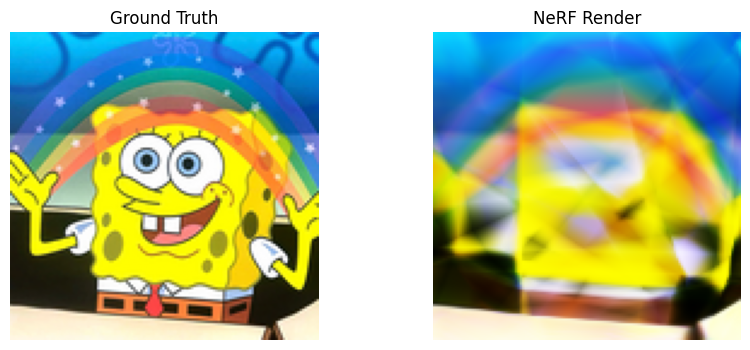

In [36]:
# Reshape the rendered image and display
rendered_image = rendered_rgb.detach().cpu().numpy().reshape(height, width, 3)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('NeRF Render')
plt.imshow(np.clip(rendered_image, 0, 1))
plt.axis('off')
plt.show()